In [8]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.geocoders import AzureMaps
from geopy.geocoders import Bing
from geopy.geocoders import HereV7
from geopy.distance import geodesic
import time
import numpy as np
from matplotlib import pyplot as plt
import joblib
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split


# Differntially Private Models
from diffprivlib.models import PCA as DPPCA
from diffprivlib.models import standard_scaler as DPStandardScaler

from diffprivlib.models import GaussianNB as DPGaussianNB
from diffprivlib.models import LogisticRegression as DPLogisticRegression
from diffprivlib.models import RandomForestClassifier as DPRandomForestClassifier


# Default Non-Private Models
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.utils import resample

from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, log_loss

from sklearn.tree import plot_tree # draw a classification tree
from sklearn.model_selection import cross_val_score # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix

from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import KBinsDiscretizer

from dtreeviz.trees import dtreeviz # remember to load the package

import seaborn as sns
import copy
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load Asset Location Data
asset_location_data = pd.read_excel('david_au_customer_data.xlsx')

# Clean Fraud Identifier Column/ Remove nan values
asset_location_data['Known Fraud'] = [0 if elem is np.nan else 1 for elem in asset_location_data['Known Fraud']]

### Separate fraud and non-fraud cases into different dataframes
fraud_df = asset_location_data[asset_location_data['Known Fraud'] == 1]
non_fraud_df = asset_location_data[asset_location_data['Known Fraud'] == 0]

### define input/output features ###
classifier_target = ['Known Fraud']
classifier_input = ['Customer Type','Business Unit','Equipment Type','Scorecard Type']

### Remove samples with na values ###
non_fraud_df =  non_fraud_df[classifier_target+classifier_input].dropna()
fraud_df =  fraud_df[classifier_target+classifier_input].dropna()

### type conversion ###
non_fraud_df[classifier_input] = non_fraud_df[classifier_input].astype(str)
fraud_df[classifier_input] = fraud_df[classifier_input].astype(str)


# define majority and minority classes
asset_location_data_majority = non_fraud_df
asset_location_data_minority = fraud_df

asset_location_data_minority_upsampled = resample(asset_location_data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=500,    # to match majority class
                                 random_state=50) # reproducible results

asset_location_data_majority_downsampled = resample(asset_location_data_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=500,    # to match majority class
                                 random_state=50) # reproducible results

 
# Combine downsampled majority class with upsampled minority class
asset_location_data = pd.concat([asset_location_data_majority_downsampled, asset_location_data_minority_upsampled])

enc = OrdinalEncoder()

asset_location_data[classifier_input] = enc.fit_transform(asset_location_data[classifier_input])


In [23]:
def add_dp_noise(x,eps):
    S = x.max(axis=0) - x.min(axis=0)
    B = S/(eps/x.shape[1])
    noise = np.random.laplace(0, B, (x.shape))
    assert x.shape == noise.shape
    x_dash = x + noise
    x_dash = x_dash.astype(np.float32)
    assert x_dash.shape == x.shape
    return x_dash

SMALL_VALUE = 0.001

def cust_log_loss(a, b):
    return [-np.log(max(b[i, a[i]], SMALL_VALUE)) for i in range(len(a))]


Classifier: rf
Varying DP Noise Applied at Stage:
2 (During Model Training
epsilon salem_mi yeom_mi test_acc_loss
0.01 0.003 0.573 0.45
0.05 -0.002 0.58 0.42
0.1 0.004 0.568 0.37
0.5 -0.008 0.647 0.3
1 -0.004 0.648 0.29
5 0.003 0.701 0.28
10 0.003 0.684 0.28
50 -0.008 0.705 0.26
100 -0.002 0.677 0.29
500 -0.011 0.631 0.31
1000 -0.006 0.645 0.29


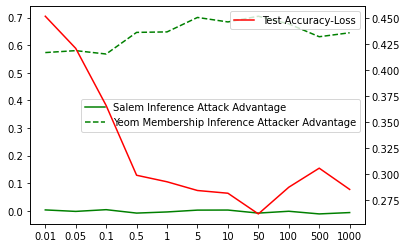

<Figure size 720x360 with 0 Axes>

In [70]:
### COMPLETE EXPERIMENT TENTATIVE ###

### DEFINE PARAMETERS ###

epsilons = [0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000]
rounds = 10
model_type = 'rf'
add_s1_noise = False
### default not used when previous value set to True ###
default_noise_value = 100
use_non_dp_defaults = True


X_train, X_test, y_train, y_test = train_test_split(asset_location_data[classifier_input],asset_location_data[classifier_target], test_size=0.2,random_state=50)
X = X_train.append(X_test)
y = y_train.append(y_test)




print('Classifier: '+str(model_type))
print('Varying DP Noise Applied at Stage:')
if add_s1_noise is True:
    print('1 (Before Model Training')
if add_s1_noise is False:
    print('2 (During Model Training')


print('epsilon','salem_mi','yeom_mi','test_acc_loss')

salem_mis = list()
yeom_mis = list()
test_accs = list()

### RUN FOR LOOP TO GENERATE PERFORMANCE & PRIVACY METRICS FOR DIFFERENT PRIVACY BUDGETS ###
for epsilon  in epsilons:
    salem_mi = 0 
    yeom_mi = 0
    test_acc = 0

    for i in range(rounds):

        dp_model_list = {'lr':DPLogisticRegression(epsilon=epsilon),
                     'nb':DPGaussianNB(epsilon=epsilon),
                     'rf':DPRandomForestClassifier(epsilon=epsilon)
                    }
        if use_non_dp_defaults is True:
            non_dp_model_list = {'lr':LogisticRegression(),
                            'nb':GaussianNB(),
                            'rf':RandomForestClassifier()
                            }
        if use_non_dp_defaults is False:
            non_dp_model_list = {'lr':LogisticRegression(epsilon=10000),
                            'nb':GaussianNB(epsilon=10000),
                            'rf':RandomForestClassifier(epsilon=10000)
                            }
        # assert model_type in dp_model_list.keys() and non_dp_model_list.keys()


        dp_classifier = dp_model_list[model_type]
        non_dp_classifier = non_dp_model_list[model_type]


        if add_s1_noise is True:    
            ### ADD DP-NOISE TO COMPLETE DATASET ###
            X_train_dash = add_dp_noise(X_train,epsilon)
            X_test_dash = add_dp_noise(X_test,epsilon)
            classifier = copy.deepcopy(non_dp_classifier)

        if add_s1_noise is False:

            X_train_dash = add_dp_noise(X_train,default_noise_value)
            X_test_dash = add_dp_noise(X_test,default_noise_value)
            classifier = copy.deepcopy(dp_classifier)


        n_classes = len(y_test['Known Fraud'].unique())


        classifier.fit(X_train_dash,y_train)
        y_train_pred = classifier.predict(X_train_dash.values)
        y_train_pred_probs = classifier.predict_proba(X_train_dash.values)
        train_acc = accuracy_score(y_train,y_train_pred)
        

        train_loss = cust_log_loss(y_train.values,y_train_pred_probs)
        sk_log_loss = log_loss(y_train.values,y_train_pred_probs)

        y_test_pred = classifier.predict(X_test_dash)
        y_test_pred_probs = classifier.predict_proba(X_test_dash.values)
        test_acc = test_acc + (1-(accuracy_score(y_test,y_test_pred)/accuracy_score(y_test,copy.deepcopy(non_dp_classifier).fit(X_train,y_train).predict(X_test))))
        test_loss = cust_log_loss(y_test.values,y_test_pred_probs)
        X_attack, y_attack = np.array([]), np.array([])

        
        X_attack = np.append(y_train_pred_probs,y_test_pred_probs,axis=0)
        y_attack = np.append(np.ones(X_train.shape[0]),np.zeros(X_test.shape[0]))

        # Prediction Probabilities for Complete Dataset
        X_attack = X_attack.astype('float32')
        # Binary Membership Value for Complete Dataset (1 for Training Data, 0 for Testing Data)
        y_attack = y_attack.astype('int32')

        
        fpr,tpr,thresholds = roc_curve(y_attack, X_attack[:,1], pos_label=1)
        salem_mi = salem_mi + (tpr[1] + tpr[0] -fpr[0]-fpr[1])
        # auc(tpr,fpr)

        loss = np.append(train_loss,test_loss)

        ls = cust_log_loss(y.values,X_attack)

        pred_membership = [1 if ls[elem] <= sk_log_loss else 0 for elem in range(len(y.values))]
        fpr, tpr, thresholds = roc_curve(y_attack, pred_membership, pos_label=1)
        yeom_mi = yeom_mi +( tpr[1] + tpr[0] )
        # tpr[1]-fpr[1]
        

        attr_adv, attr_mem, attr_pred = [], [], []

        # for feature in features:
            


        
        # print(epsilon,round(salem_mi,3),round(yeom_mi,3),round(test_acc,2))
    
    salem_mi = salem_mi/rounds
    yeom_mi = yeom_mi/rounds
    test_acc = test_acc/rounds

    print(epsilon,round(salem_mi,3),round(yeom_mi,3),round(test_acc,2))

    salem_mis.append(salem_mi)
    yeom_mis.append(yeom_mi)
    test_accs.append(test_acc)


fig,ax = plt.subplots()
plt.figure(figsize=(10,5))

ax2 = ax.twinx()

ax.plot([str(elem) for elem in epsilons],salem_mis,label='Salem Inference Attack Advantage',color='green')
ax.plot([str(elem) for elem in epsilons],yeom_mis,label='Yeom Membership Inference Attacker Advantage',color='green',linestyle='dashed')
# ax.plot([str(elem) for elem in epsilons],np.ones(len(epsilons)),label='Attribute Inference Attack Advantage')
ax2.plot([str(elem) for elem in epsilons],test_accs,label='Test Accuracy-Loss',color='red')

ax.legend()
ax2.legend()
# plt.semilogx(epsilons, accuracy)
# plt.yscale('symlog')
# ax.title("Performance-Privacy Tradeoff")
# ax.xlabel("epsilon")
# ax.ylabel("Score")

In [73]:
add_dp_noise(X_train,0.1)

,Customer Type,Business Unit,Equipment Type,Scorecard Type
38470,256.486633,518.823486,1883.476074,507.347534
39361,-1221.726807,-1445.402832,676.651245,110.296211
47669,12.684851,4660.368652,-1104.459473,-34.176197
108278,-1165.692261,4436.103027,11677.130859,32.919891
89547,406.389526,3445.006104,2136.414795,67.575279
...,...,...,...,...
91107,906.680664,-669.431885,-711.045959,-664.339661
31802,219.161942,5861.079102,3860.559814,35.577305
87085,-205.201355,674.903625,-2908.202148,1010.253906
26258,235.035980,4032.177979,7018.409180,375.325806


In [4]:

def train_model(X_train, y_train, X_test, y_test, model, epsilon=0.5):    
    
    n_out = len(y_test['Known Fraud'].unique())

    X_train_dash = add_dp_noise(X_train,epsilon)
    X_test_dash = add_dp_noise(X_test,epsilon)

    X = X_train.append(X_test)
    y = y_train.append(y_test) 


    permissible_models = {
        'ibmNB': DPGaussianNB(epsilon=epsilon),
        'ibmLR': DPLogisticRegression(epsilon=epsilon),
        'ibmRNDF': DPRandomForestClassifier(epsilon=epsilon),
        'nb': GaussianNB(),
        'lr': LogisticRegression(),
        'rndf': RandomForestClassifier(),
    }

    model_params = {
        'ibmNB': {'epsilon': epsilon, 'bounds': list(zip(np.min(X_train, axis=0), np.max(X_train, axis=0)))},
        'ibmLR': {'epsilon': epsilon, 'solver':'lbfgs', 'multi_class':'ovr', 'penalty':'l2', 'max_iter':1000, 'n_jobs':-1},
        'ibmRNDF': {'epsilon': epsilon, 'bounds': list(zip(np.min(X_train, axis=0), np.max(X_train, axis=0)))},
        'nb': {'var_smoothing': 1e-9},
        'lr': {'solver':'lbfgs', 'multi_class':'ovr', 'penalty':'l2', 'max_iter':1000, 'n_jobs':-1},
        'rndf': {'n_estimators': 100, 'max_depth': 15}
    }

    classifier = permissible_models[model]
    classifier.fit(X_train,y_train)
    y_train_pred = classifier.predict(X_train.values)
    train_acc = accuracy_score(y_train,y_train_pred)
    y_train_pred_probs = classifier.predict_proba(X_train.values)

    try:
        train_loss = log_loss(y_train,y_train_pred)
    except:
        warnings.warn("nan confidence values encountered, values have been filled with 1.0/n_classes", RuntimeWarning)
        where_isnan = np.isnan(y_train_pred_probs)
        y_train_pred_probs[where_isnan] = 1.0/n_out
        train_loss = log_loss(y_train, y_train_pred_probs)

    y_test_pred = classifier.predict(X_test)
    test_acc = accuracy_score(y_test,y_test_pred)
    y_test_pred_probs = classifier.predict_proba(X_test.values)


    X_attack, y_attack = [], []

    X_attack.append(y_train_pred_probs)
    y_attack.append(np.ones(X_train.shape[0]))

    X_attack.append(y_test_pred_probs)
    y_attack.append(np.zeros(X_test.shape[0]))

    X_attack.np.vstack(X_attack)
    X_attack = X_attack.astype('float32')
    y_attack = y_attack.astype('int32')

    return X_attack,y_attack,y, train_loss, classifier, train_acc, test_acc

### Membership Inference without Truth Label
def mlleak_membership_inference(pred_y, membership):
    print('-' * 10 + 'ML-LEAKS MEMBERSHIP INFERENCE' + '-' * 10 + '\n')
    fpr, tpr, thresholds = roc_curve(list(membership), list(pred_y), pos_label=1)
    membership_auc = auc(fpr, tpr)
    print("AUC: {}".format(membership_auc))
    return membership_auc

### Membership Inference with Truth Label
def membership_inference(true_y, pred_y, membership, train_loss):
    print('-' * 10 + 'MEMBERSHIP INFERENCE' + '-' * 10 + '\n')
    pred_membership = np.where(log_loss(true_y, pred_y) <= train_loss, 1, 0)
    fpr, tpr, thresholds = roc_curve(membership, pred_membership, pos_label=1)
    print(fpr, tpr, tpr-fpr)
    mem_adv = tpr[1]-fpr[1]
    return mem_adv, log_loss(true_y, pred_y)
    
def get_random_features(data, pool, size):

    features = set()

    while(len(features) < size):
        feat = random.choice(pool)
        a = np.unique(data[:,feat].A1)
        if len(a) > 1:
            features.add(feat)

    return list(features)





In [21]:
def preprocess_data(preprocess, x, eps):
            # Transform x, or y, but ensure the shape and datastructure is maintained
            if preprocess == 'dp-noise':
                # assert False, 'Not implemented'
                S = x.max(axis=0) - x.min(axis=0)
                B = S/(eps/x.shape[1])
                noise = np.random.laplace(0, B, (x.shape))
                assert x.shape == noise.shape
                x_dash = x + noise
                x_dash = x_dash.astype(np.float32)
                assert x_dash.shape == x.shape
            else:
                assert False, 'Invalid Preprocess'
                pass
            assert(x.shape == (x_dash.shape)), 'Pre-processing has not preserved shape of datastructure'
#             assert(x.dtype == x_dash.dtype), 'Pre-processing has not preserved datatype of datastructure {} vs. {}'.format(x.dtype, x_dash.dtype)

            return x_dash


### Membership Inference with Truth Label
def membership_inference(true_y, pred_y, membership, train_loss):
    print('-' * 10 + 'MEMBERSHIP INFERENCE' + '-' * 10 + '\n')
    pred_membership = np.where(log_loss(true_y, pred_y) <= train_loss, 1, 0)
    fpr, tpr, thresholds = roc_curve(membership, pred_membership, pos_label=1)
    print(fpr, tpr, tpr-fpr)
    mem_adv = tpr[1]-fpr[1]
    return mem_adv, log_loss(true_y, pred_y)

### Membership Inference without Truth Label
def mlleak_membership_inference(pred_y, membership):
    print('-' * 10 + 'ML-LEAKS MEMBERSHIP INFERENCE' + '-' * 10 + '\n')
    fpr, tpr, thresholds = roc_curve(list(membership), np.squeeze(np.asarray(np.max(pred_y, axis=1))), pos_label=1)
    membership_auc = auc(fpr, tpr)
    print("AUC: {}".format(membership_auc))
    return membership_auc

### Attribute Inference with Truth Label
def attribute_inference(true_x, true_y, batch_size, classifier, train_loss, features, n_classes=None, classic_model=False):
    # Batch Size is a redundant input
    print('-' * 10 + 'ATTRIBUTE INFERENCE' + '-' * 10 + '\n')

    if classic_model:
        assert n_classes is not None, "Please specify number of classes for classic models."

    attr_adv, attr_mem, attr_pred = [], [], []
    for feature in features:
        low_op, high_op = [], []

        low_data, high_data, membership = getAttributeVariations(true_x, feature)

        print('Variations Gened {}'.format(feature))

        if not classic_model:
            pred_input_fn = tf.estimator.inputs.numpy_input_fn(
                x={'x': low_data},
                num_epochs=1,
                shuffle=False)

            predictions = classifier.predict(input_fn=pred_input_fn)
            _, low_op = get_predictions(predictions)

            pred_input_fn = tf.estimator.inputs.numpy_input_fn(
                x={'x': high_data},
                num_epochs=1,
                shuffle=False)

            predictions = classifier.predict(input_fn=pred_input_fn)
            _, high_op = get_predictions(predictions)
        else:
            # Inclusion of code to handle nan confidence values
            low_op = classifier.predict_proba(low_data)
            nan_vals = np.isnan(low_op)
            if nan_vals.any():
                warnings.warn("nan confidence values encountered, values have been filled with 1.0/n_classes", RuntimeWarning)
                low_op[nan_vals] = 1.0/n_classes

            high_op = classifier.predict_proba(high_data)
            nan_vals = np.isnan(high_op)
            if nan_vals.any():
                warnings.warn("nan confidence values encountered, values have been filled with 1.0/n_classes", RuntimeWarning)
                high_op[nan_vals] = 1.0/n_classes

        low_op = low_op.astype('float32')
        high_op = high_op.astype('float32')

        low_op = log_loss(true_y, low_op)
        high_op = log_loss(true_y, high_op)

        pred_membership = np.where(stats.norm(0, train_loss).pdf(low_op) >= stats.norm(0, train_loss).pdf(high_op), 0, 1)
        fpr, tpr, thresholds = roc_curve(membership, pred_membership, pos_label=1)
        print('AI perf for {}'.format(feature))
        print(fpr, tpr, tpr-fpr)
        attr_adv.append(tpr[1]-fpr[1])

        attr_mem.append(membership)
        attr_pred.append(np.vstack((low_op, high_op)))

    return attr_adv, attr_mem, attr_pred


def getAttributeVariations(data, feature):
    low_data, high_data = np.copy(data), np.copy(data)
    pivot = np.quantile(data[:, feature], 0.5)
    low = np.quantile(data[:, feature], 0.25)
    high = np.quantile(data[:, feature], 0.75)
    membership = np.where(data[:, feature] <= pivot, 0, 1)
    low_data[:, feature] = low
    high_data[:, feature] = high
    return low_data, high_data, membership

def log_loss(a, b):
    return [-np.log(max(b[i, a[i]], SMALL_VALUE)) for i in range(len(a))]


0.0

In [101]:
epsilon = 0.5
permissible_models = {
        'ibmNB': DPGaussianNB(),
        'ibmLR': DPLogisticRegression(),
        'ibmRNDF': DPRandomForestClassifier(),
        'nb': GaussianNB(),
        'lr': LogisticRegression(),
        'rndf': RandomForestClassifier(),
    }

model_params = {
        'ibmNB': {'epsilon': epsilon, 'bounds': list(zip(np.min(X_train, axis=0), np.max(X_train, axis=0)))},
        'ibmLR': {'epsilon': epsilon, 'solver':'lbfgs', 'multi_class':'ovr', 'penalty':'l2', 'max_iter':1000, 'n_jobs':-1},
        'ibmRNDF': {'epsilon': epsilon, 'bounds': list(zip(np.min(X_train, axis=0), np.max(X_train, axis=0)))},
        'nb': {'var_smoothing': 1e-9},
        'lr': {'solver':'lbfgs', 'multi_class':'ovr', 'penalty':'l2', 'max_iter':1000, 'n_jobs':-1},
        'rndf': {'n_estimators': 100, 'max_depth': 15}
    }

n_classes = len(y_test['Known Fraud'].unique())

classifier = permissible_models['rndf']
classifier.fit(X_train,y_train)

X_train_dash = add_dp_noise(X_train,epsilon)
y_train_pred = classifier.predict(X_train_dash.values)
train_acc = accuracy_score(y_train,y_train_pred)
y_train_pred_probs = classifier.predict_proba(X_train.values)

try:
    train_loss = log_loss(y_train,y_train_pred)
except:
    warnings.warn("nan confidence values encountered, values have been filled with 1.0/n_classes", RuntimeWarning)
    where_isnan = np.isnan(y_train_pred_probs)
    y_train_pred_probs[where_isnan] = 1.0/n_out
    train_loss = log_loss(y_train, y_train_pred_probs)
    
y_test_pred = classifier.predict(X_test)
test_acc = accuracy_score(X_test,y_test_pred)
y_test_pred_probs = classifier.predict_proba(X_test)

X_attack, y_attack = [], []

X_attack.append(y_train_pred_probs)
y_attack.append(np.ones(X_train.shape[0]))

X_attack.append(y_test_pred_probs)
y_attack.append(np.zeros(X_test.shape[0]))

X_attack.np.vstack(X_attack)
X_attack = X_attack.astype('float32')
y_attack = y_attack.astype('int32')

classes = np.concatenate([y_train,y_test])

# X_attack, y_attack, test_classes, train_loss, classifier, train_acc, test_acc = train_model(X_train,y_train,X_test,y_test, n_classes,model='rndf', epsilon=0.5)
# pred_y is X_attack
# membership is y_attack

### SALEM MEMBERSHIP INFERENCE ###
mlleak_mi_auc = mlleak_membership_inference(X_attack, y_attack)

X = np.vstack((X_train,X_test))
y = np.append(y_train,y_test)

### YEOM MEMBERSHIP INFERENCE ###
mem_adv, mem_pred = membership_inference(y, X_attack, y_attack, train_loss )

features = get_random_features(X,range(X.shape[1]),20)

# ### YEOM ATTRIBUTE INFERENCE ###
# attr_adv, attr_mem, attr_pred = attribute_inference(X,y,10,classifier,train_loss,features,n_classes,False)



ValueError: Classification metrics can't handle a mix of multiclass-multioutput and binary targets

In [55]:
# X_train,add_dp_noise(X_train,1000)

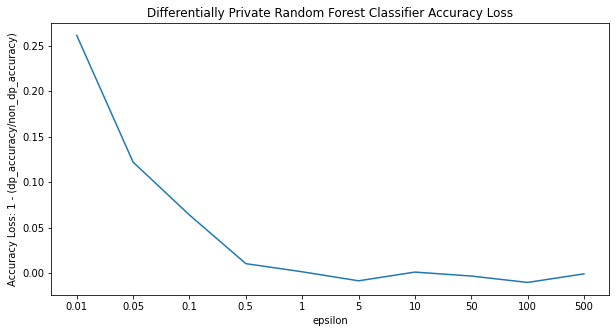

In [24]:
epsilons = [0.01,0.05,0.1,0.5,1,5,10,50,100,500]
# np.logspace(-3,4, 200)
# [0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000]
# 
# bounds = ([4.3, 2.0, 1.1, 0.1], [7.9, 4.4, 6.9, 2.5])
accuracy_loss = list()
rounds = 500

for epsilon in epsilons:

    acl_score = 0
    for i in range(rounds):

        dp_model = DPRandomForestClassifier(epsilon=epsilon)
        non_dp_model = DPRandomForestClassifier(epsilon=100000000)
        #RandomForestClassifier()
        
        dp_model.fit(X_train, y_train)
        non_dp_model.fit(X_train,y_train)

        acl_score = acl_score + (1 - (dp_model.score(X_test,y_test)/non_dp_model.score(X_test,y_test)))
    
    acl_score = acl_score/rounds    


    accuracy_loss.append(acl_score)

plt.figure(figsize=(10,5))
plt.plot([str(elem) for elem in epsilons],accuracy_loss)
# plt.semilogx(epsilons, accuracy)
# plt.yscale('symlog')
plt.title("Differentially Private Random Forest Classifier Accuracy Loss")
plt.xlabel("epsilon")
plt.ylabel("Accuracy Loss: 1 - (dp_accuracy/non_dp_accuracy)")
plt.show()


array([[12., 15., 75.,  0.]])

In [51]:
dp_model.predict_proba(X_test.head(1).values)
dp_model.predict(X_test.head(1).values)


array([1], dtype=int64)